## Project :  Analyze A/B Test Results
### By Somya Bharti

I will be working in this project to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. Here, I'll help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B testing (also known as split testing or bucket testing) is a method of comparing two versions of a webpage or app against each other to determine which one performs better. AB testing is essentially an experiment where two or more variants of a page are shown to users at random, and statistical analysis is used to determine which variation performs better for a given conversion goal.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [45]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

### Gathering Data

In [2]:
df=pd.read_csv('ab_data.csv')

In [46]:
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


- Number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

- Number of unique users in the dataset.

In [47]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

- The proportion of users converted.

> We will find the number of people converted to total number of people.

In [50]:
len(df[df['converted'] == 1])/df.shape[0]

0.11965919355605512

- The number of times the `new_page` and `treatment` don't line up.

> For this, there can be two cases.
- First when the treatment group lands on an old page instead of new page.
- Second, when the control group lands on new page instead of old page.

In [53]:
df.query ('group == "treatment" and landing_page == "old_page"').shape[0]

1965

In [54]:
df.query ('group == "control" and landing_page == "new_page"').shape[0]

1928

> Let's find the missing values

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


- As we see that total number of rows are 294478 and each column consists of 294478 entries, there are no missing values in the dataset.

> For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

- We should only use the rows that we can feel confident in the accuracy of the data so we will drop the rows wherever there is misalignment.



Reference - https://kite.com/python/answers/how-to-delete-rows-from-a-pandas-%60dataframe%60-based-on-a-conditional-expression-in-python

In [56]:
df2 = df.drop(df[((df.landing_page == 'new_page') & (df.group == 'control')) |
                 ((df.landing_page == 'old_page') & (df.group == 'treatment'))].index)



In [59]:
df2.shape

(290585, 5)

In [57]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

 > Unique **user_id**s are in **df2**

In [12]:
df2.nunique().user_id

290584

> As we see that total number of users are 290585 and unique users are 290584, we need to find the duplicate user id and remove it from our dataset. 

https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python

In [13]:
ids = df2["user_id"]
ids.duplicated().sum()

1

> Row information for the repeat **user_id**

In [60]:
df2[ids.isin(ids[ids.duplicated()])]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


> Removed **one** of the rows with a duplicate **user_id**.

In [61]:
df2 = df2[~df2.user_id.duplicated(keep='first')]
# https://stackoverflow.com/questions/13035764/remove-rows-with-duplicate-indices-pandas-dataframe-and-timeseries


In [62]:
df2.shape

(290584, 5)

> Probability of an individual converting regardless of the page they receive.

- Sum of people converted

In [17]:
(df2.converted==1).sum()

34753

- Sum of people didn't convert

In [18]:
(df2.converted==0).sum()

255831

- Probability

In [19]:
(df2.converted==1).mean()

0.11959708724499628

>Probability they converted such that an individual was in the `control` group.

In [64]:
control_=df2.converted[df2.group=='control'].mean()
control_

0.1203863045004612

>Probability they converted such that an individual was in the `treatment` group.

In [63]:
treatment_=df2.converted[df2.group=='treatment'].mean()
treatment_

0.11880806551510564

> Now, we will find the difference between the people under treatment group who converted and people under control group who converted.

In [65]:
observed_diff = treatment_ - control_
observed_diff


-0.0015782389853555567

>Probability that an individual received the new page

In [66]:
p_new_page=len(df2[df2['landing_page'] == "new_page"])/df2.shape[0]
p_new_page

0.5000619442226688

>Probability that an individual received the old page

In [68]:
1-p_new_page

0.4999380557773312

### Observations from the above statistics :

**The probability of an individual of control group converting is 0.12 whereas the probability of an individual of treatment group converting is 0.11. Also, the probability of an individual landing on a new page is 0.5 which is not more when compared to landing on old page. Hence, we observe that there is no such vast difference between the treatment group and control group to conculde which page is better for increasing convert rate.**

<a id='ab_test'></a>
### Part II - A/B Test


> Now, we will make the decision just based on all the data provided.For this, we will perform hypothesis testing to check whether our calculated observations are right or not. For performing this test we consider two types of Hypothesis that is Null and Alternative Hypothesis.

- Null Hypothesis(**$p_{old}$**) - The probability of coversion on old page is better than new page.

- Alternative Hypothesis( **$p_{new}$**) - The probability of conversion on new page is better. 

Now, we will assume that under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assumed that they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>




> **Convert rate** for $p_{new}$ under the null

In [69]:
p_new=df2['converted'].mean()
p_new

0.11959708724499628

> **Convert rate** for $p_{old}$ under the null

In [25]:
p_old=df2['converted'].mean()
p_old

0.11959708724499628

> $n_{new}$

In [26]:
n_new=len(df2[df2['landing_page'] == "new_page"])
n_new

145310

 $n_{old}$

In [70]:
n_old=len(df2[df2['landing_page'] == "old_page"])
n_old

145274

Now we will simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null using random choice.

In [28]:
new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
new_page_converted.mean()

0.11979216846741449

> Simulated $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. 

In [29]:
old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
old_page_converted.mean()

0.11922986907498934

>Now we will find $p_{new}$ - $p_{old}$ for our simulated values.

In [30]:
new_page_converted.mean()-old_page_converted.mean()

0.0005622993924251501

>Now we will use a sample size for each page equal to the ones in **ab_data.csv** and perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  

Stored all 10,000 values in a numpy array called **p_diffs**.

In [31]:
# create sampling distribution of difference with boostrapping 

p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
    old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    

In [32]:
p_diffs[:10]

[-0.00024990425118395776,
 -0.0007042215790774159,
 -0.0009176660211546589,
 -0.0005735178025151333,
 -8.460539494761776e-05,
 -0.0003739154852000909,
 -0.00045623151311129095,
 -7.799471025279892e-05,
 -0.0006489468754833083,
 0.0013126739250181318]

>Histogram of the **p_diffs**. 

In [71]:
p_diffs = np.array(p_diffs)

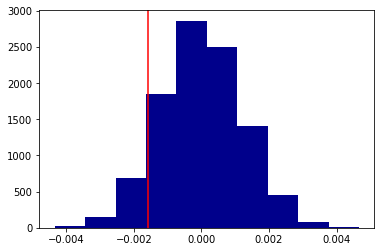

In [72]:
plt.hist(p_diffs,color='#00008b');
plt.axvline(observed_diff, c='r')

Proportion of the **p_diffs** when they are greater than the actual difference observed in **ab_data.csv**

In [73]:
(p_diffs>observed_diff).mean()

0.9065

>### Obsevations from the above plot:
- The proportion is which we just calculated above is p-value.The p-value is the probability of getting our statistic or a more extreme value if the null is true.
- Therefore, small p-values suggest our null is not true. Our statistic is likely to have come from a different distribution than the null.
- When the p-value is large, we have evidence that our statistic was likely to come from the null hypothesis. Therefore, we do not have evidence to reject the null.
- **In this project, we have taken Type 1 error into consideration for which alpha value is 0.05.
Here our calculated p-value is 0.9065 which is too large than alpha value. So we, cannot reject the null hypothesis in this case.**

> We can also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.
- Below we have calculated the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [74]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"')['converted'].count()
n_new = df2.query('landing_page == "new_page"')['converted'].count()

> Used `stats.proportions_ztest` to compute our test statistic and p-value.  

https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html

In [78]:
from statsmodels.stats.proportion import proportions_ztest
z, pval = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative='smaller')
z,pval


(1.3109241984234394, 0.9050583127590245)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

In [80]:
from scipy.stats import norm
norm.ppf(1-(0.05/2))

1.959963984540054

> ### Observations from z-score and p-value:
- The value of the z-score tells you how many standard deviations you are away from the mean.If a z-score is equal to 0, it is on the mean. If a Z-Score is equal to +1, it is 1 Standard Deviation above the mean. If a z-score is equal to +2, it is 2 Standard Deviations above the mean. 
- Here our z-score is 1.31 which does not exceeds 1.95 that is it provides a clear cut explanation of not rejecting the null hypothesis.
- Our p-value is again 0.905 which is larger than 0.05 and so it denotes the failure of rjecting null hypothesis. 

<a id='regression'></a>
### Part III - A regression approach

- In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion,

**Put your answer here.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [38]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop(['control'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [39]:
df2['intercept'] = 1
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        12:47:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [43]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [44]:
### Create the necessary dummy variables
df_new[['UK', 'US']] = pd.get_dummies(df_new['country'])[['UK','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
### Fit Your Linear Model And Obtain the Results
df_new[['UK', 'US']] = pd.get_dummies(df_new['country'])[['UK','US']]
df_new.head()

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.